In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [22]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, Column, Integer, Float, String, Date, func
from sqlalchemy.orm import sessionmaker


In [24]:
# Create engine using the `hawaii.sqlite` database file
#Connects to the SQLite db
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [25]:
# Declare a Base using `automap_base()
#Reflects tables into ORM Classes
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\gmyou\AppData\Local\Temp\ipykernel_8144\1500613533.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [26]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['station', 'measurement']


In [27]:
# Assign the measurement class to a variable called `Measurement` and
#Save references to the station and measurement tables 
Measurement = Base.classes.measurement
# the station class to a variable called `Station`
Station = Base.classes.station

In [28]:
# Create a session
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [29]:
# Find the most recent date in the data set.

class Measurement(Base):
    __tablename__ = 'measurement'
    id = Column(Integer, primary_key=True)
    station = Column(String)
    date = Column(Date)
    prcp = Column(Float)  
    tobs = Column(Integer)  
    __table_args__ = {'extend_existing': True}  
    
# Step 3: Create a session
Session = sessionmaker(bind=engine)
session = Session()

# Step 4: Query for the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the most recent date
print("Most Recent Date:", most_recent_date)

# Close session when done 
session.close()

Most Recent Date: 2017-08-23


In [30]:
# Check all columns mapped for the Measurement table
print(Measurement.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']


Date One Year Ago: 2016-08-23
[(datetime.date(2016, 8, 23), 0.0), (datetime.date(2016, 8, 23), 0.15), (datetime.date(2016, 8, 23), 0.05), (datetime.date(2016, 8, 23), None), (datetime.date(2016, 8, 23), 0.02)]
        date  prcp
0 2016-08-23  0.00
1 2016-08-23  0.15
2 2016-08-23  0.05
3 2016-08-23   NaN
4 2016-08-23  0.02


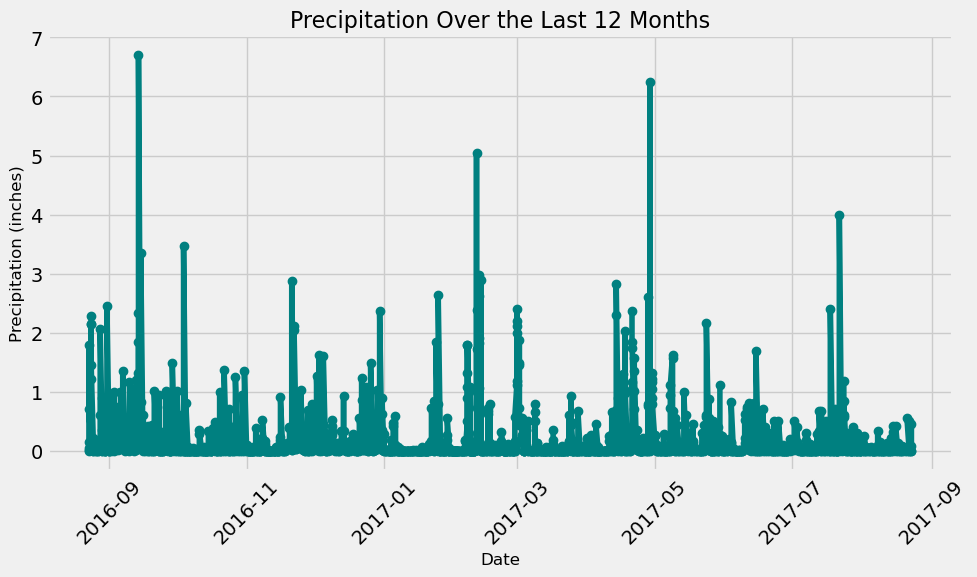

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.

from datetime import timedelta


most_recent_date = session.query(func.max(Measurement.date)).scalar()
year_ago_date = most_recent_date - timedelta(days=365)
print(f"Date One Year Ago: {year_ago_date}")


# Perform a query to retrieve the data and precipitation scores

# Query precipitation data for the last 12 months
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= year_ago_date)
    .order_by(Measurement.date)
    .all()
)

# Print the first few rows of data
print(precipitation_data[:5])

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "prcp"])

# Sort the dataframe by date
# Convert the 'date' column to datetime
precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])

# Print the first few rows of the DataFrame
print(precipitation_df.head()) 



# Using Pandas Plotting with Matplotlib and plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df["date"], precipitation_df["prcp"], marker='o', linestyle='-', color='teal')
plt.title("Precipitation Over the Last 12 Months", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (inches)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.prcp.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_station = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .first()
)

print(f"Most active station: {most_active_station[0]}, Observations: {most_active_station[1]}")

Most active station: USC00519281, Observations: 2772


In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == most_active_station[0])
    .first()
)

print(f"Min Temp: {station_stats[0]}, Max Temp: {station_stats[1]}, Avg Temp: {station_stats[2]}")

Min Temp: 54.0, Max Temp: 85.0, Avg Temp: 71.66378066378067


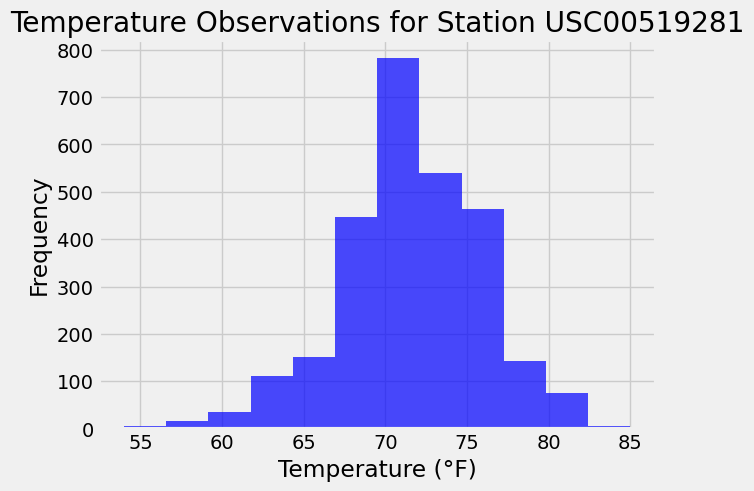

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station[0])
    .all()
)

# Convert the query result to a list of temperatures
temps = [temp[0] for temp in temps]

# Plot the histogram
plt.hist(temps, bins=12, color='blue', alpha=0.7)
plt.title(f"Temperature Observations for Station {most_active_station[0]}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [37]:
# Close Session
session.close()
